In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
# Network Parameters
num_input = 6
timesteps = 50 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [6]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

    p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
    all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_feature)):
        start_time = int(float(all_feature[i][0])*25)
        end_time = int(float(all_feature[i][1])*25)
        for t in range(start_time-1, end_time):
            window_y[t] = [0.5]
            
#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j:j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [7]:
all_train_data_list = []
#[4, 6, '2R', 'WC']
for i in range(1,7): #1,2,3,5,6,  7,8,  9, 10
    all_train_data_list.append([i, 11, '1L', 'NA'])
    all_train_data_list.append([i, 12, '1L', 'NA'])
    all_train_data_list.append([i, 13, '1L', 'NA'])
    all_train_data_list.append([i, 14, '1L', 'NA'])
#     step_data_list.append([i, 15, '1L', 'NA'])
    all_train_data_list.append([i, 11, '2R', 'NA'])
    all_train_data_list.append([i, 12, '2R', 'NA'])
    all_train_data_list.append([i, 13, '2R', 'NA'])
    all_train_data_list.append([i, 14, '2R', 'NA'])
#     step_data_list.append([i, 15, '2R', 'NA'])    
    
print(all_train_data_list)

[[1, 11, '1L', 'NA'], [1, 12, '1L', 'NA'], [1, 13, '1L', 'NA'], [1, 14, '1L', 'NA'], [1, 11, '2R', 'NA'], [1, 12, '2R', 'NA'], [1, 13, '2R', 'NA'], [1, 14, '2R', 'NA'], [2, 11, '1L', 'NA'], [2, 12, '1L', 'NA'], [2, 13, '1L', 'NA'], [2, 14, '1L', 'NA'], [2, 11, '2R', 'NA'], [2, 12, '2R', 'NA'], [2, 13, '2R', 'NA'], [2, 14, '2R', 'NA'], [3, 11, '1L', 'NA'], [3, 12, '1L', 'NA'], [3, 13, '1L', 'NA'], [3, 14, '1L', 'NA'], [3, 11, '2R', 'NA'], [3, 12, '2R', 'NA'], [3, 13, '2R', 'NA'], [3, 14, '2R', 'NA'], [4, 11, '1L', 'NA'], [4, 12, '1L', 'NA'], [4, 13, '1L', 'NA'], [4, 14, '1L', 'NA'], [4, 11, '2R', 'NA'], [4, 12, '2R', 'NA'], [4, 13, '2R', 'NA'], [4, 14, '2R', 'NA'], [5, 11, '1L', 'NA'], [5, 12, '1L', 'NA'], [5, 13, '1L', 'NA'], [5, 14, '1L', 'NA'], [5, 11, '2R', 'NA'], [5, 12, '2R', 'NA'], [5, 13, '2R', 'NA'], [5, 14, '2R', 'NA'], [6, 11, '1L', 'NA'], [6, 12, '1L', 'NA'], [6, 13, '1L', 'NA'], [6, 14, '1L', 'NA'], [6, 11, '2R', 'NA'], [6, 12, '2R', 'NA'], [6, 13, '2R', 'NA'], [6, 14, '2R'

In [8]:
step_train_data_list = []
step_valid_data_list = []
for i in range(11, 15):
    if(i==4):
        continue
    step_train_data_list_part = [j for j in all_train_data_list if j[1]!=i]
    step_valid_data_list_part = [j for j in all_train_data_list if j[1]==i]
    print(len(step_train_data_list_part))
    print(step_train_data_list_part)
    print('-----')
    print(len(step_valid_data_list_part))
    print(step_valid_data_list_part)
    print('=====')
    step_train_data_list.append(step_train_data_list_part)
    step_valid_data_list.append(step_valid_data_list_part)
    
    

36
[[1, 12, '1L', 'NA'], [1, 13, '1L', 'NA'], [1, 14, '1L', 'NA'], [1, 12, '2R', 'NA'], [1, 13, '2R', 'NA'], [1, 14, '2R', 'NA'], [2, 12, '1L', 'NA'], [2, 13, '1L', 'NA'], [2, 14, '1L', 'NA'], [2, 12, '2R', 'NA'], [2, 13, '2R', 'NA'], [2, 14, '2R', 'NA'], [3, 12, '1L', 'NA'], [3, 13, '1L', 'NA'], [3, 14, '1L', 'NA'], [3, 12, '2R', 'NA'], [3, 13, '2R', 'NA'], [3, 14, '2R', 'NA'], [4, 12, '1L', 'NA'], [4, 13, '1L', 'NA'], [4, 14, '1L', 'NA'], [4, 12, '2R', 'NA'], [4, 13, '2R', 'NA'], [4, 14, '2R', 'NA'], [5, 12, '1L', 'NA'], [5, 13, '1L', 'NA'], [5, 14, '1L', 'NA'], [5, 12, '2R', 'NA'], [5, 13, '2R', 'NA'], [5, 14, '2R', 'NA'], [6, 12, '1L', 'NA'], [6, 13, '1L', 'NA'], [6, 14, '1L', 'NA'], [6, 12, '2R', 'NA'], [6, 13, '2R', 'NA'], [6, 14, '2R', 'NA']]
-----
12
[[1, 11, '1L', 'NA'], [1, 11, '2R', 'NA'], [2, 11, '1L', 'NA'], [2, 11, '2R', 'NA'], [3, 11, '1L', 'NA'], [3, 11, '2R', 'NA'], [4, 11, '1L', 'NA'], [4, 11, '2R', 'NA'], [5, 11, '1L', 'NA'], [5, 11, '2R', 'NA'], [6, 11, '1L', 'NA'],

In [9]:
batch_size = 256
train_x_list, train_y_list = [], []
print(batch_size)

for step_train_data in step_train_data_list:
    data_x, data_y = [], []
    
    for i in step_train_data:
        data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
        for dx in data_x_segement:
            data_x.extend(dx)
        for dy in data_y_segement:
            data_y.extend(dy)
    
    print(len(data_x))
#     print(len(data_y))
    
    order = list(range(0,len(data_x),1))
    random.shuffle(order)

    train_x = [data_x[i] for i in order]
#     train_x.extend([i for i in train_x[:batch_size]])
    train_x.extend([train_x[i] for i in range(0, batch_size)])
    train_y = [data_y[i] for i in order]
#     train_y.extend([i for i in train_y[:batch_size]])
    train_y.extend([train_y[i] for i in range(0, batch_size)])

    print(len(train_x))
    
    train_x_list.append(train_x)
    train_y_list.append(train_y)

256
75455
75711
79302
79558
74495
74751
70307
70563


In [10]:
valid_x_list, valid_y_list = [], []

for step_valid_data in step_valid_data_list:
    valid_x, valid_y=[], []
    for i in step_valid_data:
        data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
        valid_x.extend(data_x_segement)
        valid_y.extend(data_y_segement)
    
    print(len(valid_x))
#     print(len(valid_y))
    
    valid_x_list.append(valid_x)
    valid_y_list.append(valid_y)

60
55
62
58


In [11]:
step_test_list = []
for i in range(1,7):
    step_test_list.append([i, 11, '1L', 'NA'])
#     step_test_list.append([i, 12, '1L', 'NA'])
#     step_test_list.append([i, 13, '1L', 'NA'])
#     step_test_list.append([i, 14, '1L', 'NA'])
#     step_test_list.append([i, 15, '1L', 'NA'])
    step_test_list.append([i, 11, '2R', 'NA'])
#     step_test_list.append([i, 12, '2R', 'NA'])
#     step_test_list.append([i, 13, '2R', 'NA'])
#     step_test_list.append([i, 14, '2R', 'NA'])
#     step_test_list.append([i, 15, '2R', 'NA'])    
        
print(step_test_list)

[[1, 11, '1L', 'NA'], [1, 11, '2R', 'NA'], [2, 11, '1L', 'NA'], [2, 11, '2R', 'NA'], [3, 11, '1L', 'NA'], [3, 11, '2R', 'NA'], [4, 11, '1L', 'NA'], [4, 11, '2R', 'NA'], [5, 11, '1L', 'NA'], [5, 11, '2R', 'NA'], [6, 11, '1L', 'NA'], [6, 11, '2R', 'NA']]


In [12]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

60
60
[35, 88, 761, 71, 35, 88, 761, 71, 63, 1154, 125, 70, 63, 1154, 125, 70, 1016, 270, 1016, 270, 223, 1069, 112, 1071, 105, 791, 92, 719, 223, 1069, 112, 1071, 105, 791, 92, 719, 46, 324, 577, 244, 348, 262, 1096, 46, 324, 577, 244, 348, 262, 1096, 10, 366, 5, 1035, 51, 10, 366, 5, 1035, 51]


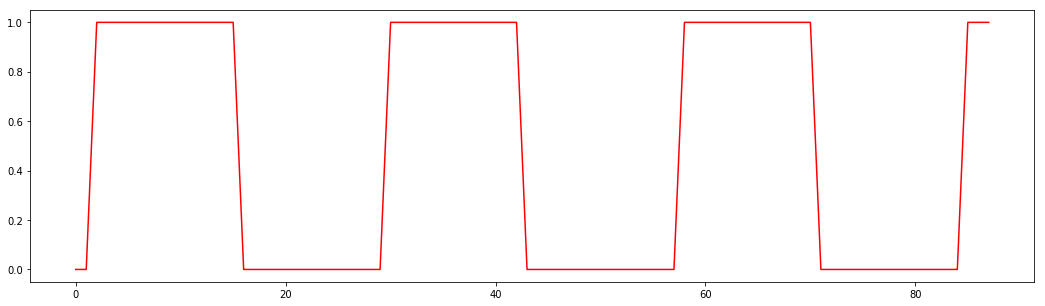

In [14]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [15]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, timesteps, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

#         return tf.matmul(outputs[-2], weights['out']) + biases['out']
        ret = []
#         print(outputs.shape)
        for i in range(0, timesteps):
            ret.append(tf.matmul(outputs[i], weights['out']) + biases['out'])
            
        return ret

#         return np.array(ret)
    
    logits = RNN(X, weights, biases)
    logits = tf.transpose(logits, [1,0,2])
#     print(len(logits))
    print(logits.shape)
    print(logits[0].shape)
    mean_train = tf.reduce_mean(X)
    
    
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

(?, 50, 1)
(50, 1)


In [16]:
def cal_accuarcy(y, _y):
#     print(len(y))
#     print(len(y[0]))
#     print(len(y[0][0]))
#     print(y[0][0])
    count = 0
    total = 0
    for i in range(len(y[0])):
        total += 1
        if(y[0][i][0] == round(_y[0][i][0])):
            count += 1
    for i in range(1, len(y)):
        total += 1
        if(y[i][-1][0] == round(_y[i][-1][0])):
            count += 1;
    return(count*1.0/total)
#     print("train accuarcy : ", count/len(y))

In [202]:
training_steps = 1
valid_loss_list, valid_logits_list = [], []
test_loss_list, test_logits_list = [], []

for i in range(0, 1):
    batch_start=0
    print("cross validation ", i)
#     batch_start = 0
    train_x = train_x_list[i]
    train_y = train_y_list[i]
    train_length = len(train_x_list[i])-256
    valid_x = valid_x_list[i]
    valid_y = valid_y_list[i]
    config = tf.ConfigProto(allow_soft_placement=True)
    with tf.Session(graph=graph, config=config) as session:
        saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#         saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-0.ckpt-4000")
#         tf.global_variables_initializer().run()
        print('Initialized')
        for step in range(training_steps):      
            feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
            _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
            if (step % 200 == 0):
                train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
                print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
                #train accuarcy
            if (step % 1000 == 0):
                saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-'+str(i)+'.ckpt', global_step=step+10000)
            batch_start += batch_size
            if(batch_start>=train_length):
                batch_start -=train_length
        valid_loss, valid_logits = [], []
        for j in range(len(valid_x)):
            valid_loss_part, valid_logits_part = session.run([loss,logits], feed_dict={X: valid_x[j], Y: valid_y[j]})
            valid_loss.append(valid_loss_part)
            valid_logits.append(valid_logits_part)

        valid_loss_list.append(valid_loss)
        valid_logits_list.append(valid_logits)

        test_loss, test_logits = [], []
        for j in range(len(test_x)):
            test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[j], Y: test_y[j]})
            test_loss.append(test_loss_part)
            test_logits.append(test_logits_part)

        test_loss_list.append(test_loss)
        test_logits_list.append(test_logits)

cross validation  0
INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-0.ckpt-10000
Initialized
Loss at step 0: 0.028624, train accuarcy : 0.977049


In [203]:
print("test loss : ", test_loss)

test loss :  [0.59446901, 0.57747549, 0.50950617, 0.55634445, 0.21437338, 0.15182175, 0.1805715, 0.15220122, 0.56512094, 0.54892778, 0.56041467, 0.45109847, 0.13399313, 0.17227222, 0.21667907, 0.15482037, 0.55920291, 0.57119113, 0.2169098, 0.35201386, 0.55872214, 0.51089048, 0.51151621, 0.52285767, 0.52599293, 0.49452117, 0.55405796, 0.54634279, 0.22635046, 0.1641202, 0.1891083, 0.19356629, 0.1264616, 0.19934265, 0.23691082, 0.19869219, 0.32698646, 0.42439711, 0.46261644, 0.45594805, 0.4899981, 0.48403078, 0.5307042, 0.15651771, 0.218321, 0.25715634, 0.25138605, 0.23365143, 0.26216924, 0.28433061, 0.41094965, 0.52150935, 0.50961643, 0.48648667, 0.4570179, 0.16304877, 0.17573509, 0.15036663, 0.22863266, 0.28726128]


60
60


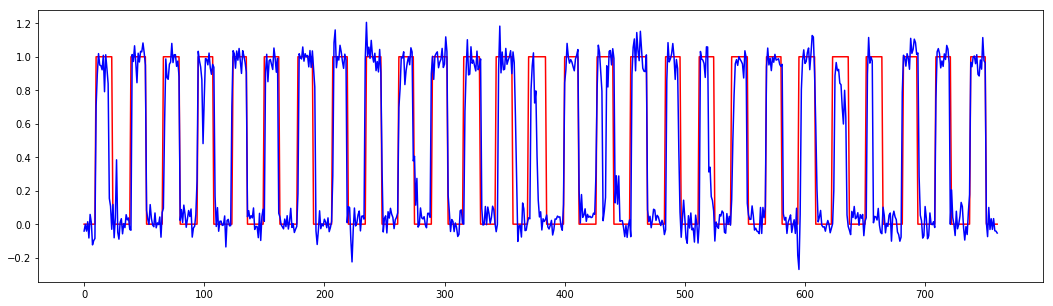

In [204]:
print(len(test_y))
print(len(test_logits_list[0]))

index = 0
index1= 6

test_logits = test_logits_list[index]


plt.figure(figsize=(18, 5))
start=0
end=2000
plt.plot([i[-1][0] for i in test_y[index1][start:end]], 'r')
plt.plot([i[-1][0] for i in test_logits[index1][start:end]], 'b')
plt.show()

In [205]:
print(len(test_logits))
print(len(test_logits[0]))
print(len(test_logits[0][0]))  

test_y_seq_list, test_logits_bin_list = [], []

for t in test_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    for i in range(1, len(t_all)-1):
        if(t_all[i-1][0]-t_all[i][0]>0.5 and t_all[i+1][0]-t_all[i][0]>0.5):
            t_all[i][0]=(t_all[i-1][0]+t_all[i+1][0])
        if(t_all[i-1][0]-t_all[i][0]>0.5 and t_all[i+1][0]-t_all[i][0]>0.5):
            t_all[i][0]=(t_all[i-1][0]+t_all[i+1][0])/2

    
    test_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin_list.append(test_logits_part)
    
for t in test_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    test_y_seq_list.append(t_all)

# print(test_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(test_y_seq_list)):
    total += len(test_y_seq_list[i])
    for j in range(0, len(test_y_seq_list[i])):
        if(test_y_seq_list[i][j][0] == test_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

60
35
50
16199
27338
test accuarcy :  0.5925451752139879


60
60


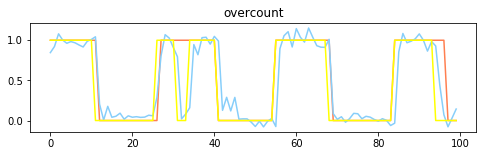

In [226]:
print(len(test_y))
print(len(test_logits_list[0]))

index = 0
index1= 6

test_logits = test_logits_list[index]


plt.figure(figsize=(8, 2))
start=400
end=500
plt.title('overcount')
plt.plot([i[-1][0] for i in test_y[index1][start:end]], 'coral')
plt.plot([i[-1][0] for i in test_logits[index1][start:end]], 'lightskyblue')

plt.plot([i[0] for i in test_logits_bin_list[index1][start+timesteps:end+timesteps]], 'yellow')

plt.show()

In [197]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#test_y_seq_list, test_logits_bin_list
for i in range(0, len(test_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(test_y_seq_list[i])):
        if(abs(test_y_seq_list[i][j][0]-test_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin_list[i][j][0]-test_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
print(step_time_actual[iii])
print(step_time_actual_gap[iii])
print(step_time_predict[iii])

Step number for each segement
[5, 10, 58, 8, 5, 10, 58, 8, 8, 84, 12, 7, 8, 84, 12, 7, 79, 22, 79, 22, 20, 80, 10, 79, 11, 60, 10, 54, 20, 80, 10, 79, 11, 60, 10, 54, 6, 26, 44, 20, 27, 21, 82, 6, 26, 44, 20, 27, 21, 82, 4, 30, 3, 77, 6, 4, 30, 3, 77, 6]
[10, 14, 65, 11, 7, 11, 61, 9, 13, 86, 12, 8, 9, 87, 14, 7, 78, 22, 86, 33, 27, 81, 15, 84, 13, 67, 11, 54, 22, 82, 12, 87, 12, 80, 9, 63, 11, 36, 52, 22, 43, 32, 71, 8, 30, 51, 26, 33, 21, 91, 7, 34, 4, 73, 8, 5, 28, 6, 99, 6]
[12, 26, 40, 55, 69, 82, 96, 110, 124, 137, 153, 164, 177, 191, 205, 218, 233, 246, 261, 275, 288, 302, 316, 330, 343, 359, 372, 387, 399, 412, 427, 440, 453, 467, 483, 495, 510, 525, 538, 553, 566, 581, 594, 609, 623, 637, 650, 665, 679, 694, 709, 723, 738, 753, 767, 782, 796, 812, 825, 840, 854, 869, 884, 897, 911, 925, 939, 955, 969, 983, 998, 1012, 1027, 1042, 1056, 1070, 1086, 1098, 1113, 1129, 1143, 1160, 1173, 1189]
[0, 19.0, 33.0, 47.5, 62.0, 75.5, 89.0, 103.0, 117.0, 130.5, 145.0, 158.5, 170.5, 184.0, 1

In [198]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(test_x))

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

60
60
535
[5, 6, 25, 5, 2, 1, 4, 1, 6, 28, 3, 3, 1, 3, 3, 0, 11, 8, 7, 13, 11, 32, 7, 31, 5, 27, 3, 15, 3, 2, 2, 8, 1, 21, 0, 10, 6, 18, 25, 7, 22, 15, 23, 2, 4, 7, 6, 6, 0, 10, 4, 9, 1, 24, 4, 2, 0, 3, 23, 1]
60
252
[5, 4, 7, 3, 2, 1, 3, 1, 5, 2, 0, 1, 1, 3, 2, 0, 0, 0, 7, 11, 7, 1, 5, 5, 2, 7, 1, 0, 2, 2, 2, 8, 1, 20, 0, 9, 5, 10, 8, 2, 16, 11, 0, 2, 4, 7, 6, 6, 0, 9, 3, 4, 1, 0, 2, 1, 0, 3, 22, 0]
error : 
total undercount metric 1:	 0.23935617860851505
total overcount metric 1:	 0.32242990654205606
total undercount metric 2:	 0.15680166147455868
total overcount metric 2:	 0.2777777777777778
total undercount metric 3:	 0.009865005192107996
total overcount metric 3:	 0.1308411214953271


# xxx

60
60


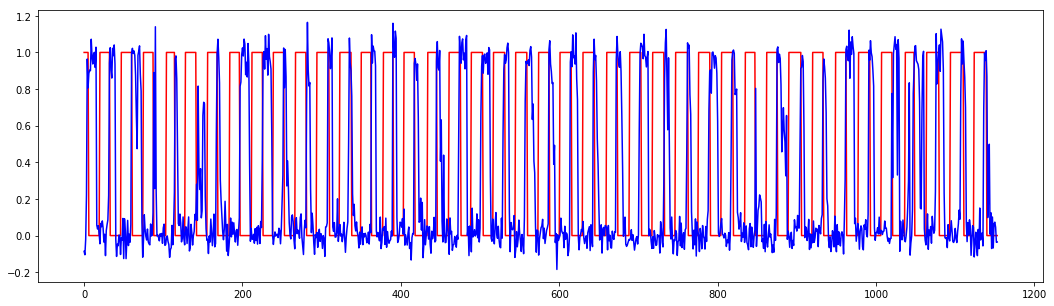

In [135]:
print(len(valid_y))
print(len(valid_logits_list[0]))

# index=1

valid_logits = valid_logits_list[index]
valid_y = valid_y_list[index]


index1=9

plt.figure(figsize=(18, 5))
start=0
end=2000
plt.plot([i[-1][0] for i in valid_y[index1][start:end]], 'r')
plt.plot([i[-1][0] for i in valid_logits[index1][start:end]], 'b')
plt.show()

In [136]:
print(len(valid_logits), len(valid_logits[0]), len(valid_logits[0][0]))


print(len(valid_y))
print(len(valid_y[0]))
print(len(valid_y[0][0]))  

valid_y_seq_list, valid_logits_bin_list = [], []

for t in valid_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    valid_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(valid_logits_part)-1):
        if(valid_logits_part[i-1][0]!=valid_logits_part[i][0] and valid_logits_part[i-1][0]==valid_logits_part[i+1][0]):
            valid_logits_part[i][0]=valid_logits_part[i-1][0]  
    
    valid_logits_bin_list.append(valid_logits_part)
    
for t in valid_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    valid_y_seq_list.append(t_all)

# print(valid_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(valid_y_seq_list)):
    total += len(valid_y_seq_list[i])
#     print(len(valid_y_seq_list[i]), len(valid_logits_bin_list[i]))
    
    for j in range(0, len(valid_y_seq_list[i])):
        if(valid_y_seq_list[i][j][0] == valid_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("valid accuarcy : ", count*1.0/total)

60 35 50
60
35
50
16266
27338
valid accuarcy :  0.5949959762967298


In [137]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#valid_y_seq_list, valid_logits_bin_list
for i in range(0, len(valid_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(valid_y_seq_list[i])):
        if(abs(valid_y_seq_list[i][j][0]-valid_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(valid_logits[i][0]-valid_logits[i-1][0])>0.5):
        if(abs(valid_logits_bin_list[i][j][0]-valid_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
print(step_time_actual[iii])
print(step_time_actual_gap[iii])
print(step_time_predict[iii])

Step number for each segement
[5, 10, 58, 8, 5, 10, 58, 8, 8, 84, 12, 7, 8, 84, 12, 7, 79, 22, 79, 22, 20, 80, 10, 79, 11, 60, 10, 54, 20, 80, 10, 79, 11, 60, 10, 54, 6, 26, 44, 20, 27, 21, 82, 6, 26, 44, 20, 27, 21, 82, 4, 30, 3, 77, 6, 4, 30, 3, 77, 6]
[10, 14, 61, 11, 7, 11, 62, 9, 12, 82, 12, 8, 8, 89, 12, 7, 78, 26, 86, 31, 25, 83, 15, 85, 13, 66, 12, 56, 23, 84, 14, 84, 12, 76, 11, 61, 11, 42, 54, 26, 43, 34, 71, 8, 30, 51, 30, 31, 22, 91, 6, 38, 4, 72, 8, 5, 30, 6, 101, 8]
[12, 26, 40, 55, 69, 82, 96, 110, 124, 137, 153, 164, 177, 191, 205, 218, 233, 246, 261, 275, 288, 302, 316, 330, 343, 359, 372, 387, 399, 412, 427, 440, 453, 467, 483, 495, 510, 525, 538, 553, 566, 581, 594, 609, 623, 637, 650, 665, 679, 694, 709, 723, 738, 753, 767, 782, 796, 812, 825, 840, 854, 869, 884, 897, 911, 925, 939, 955, 969, 983, 998, 1012, 1027, 1042, 1056, 1070, 1086, 1098, 1113, 1129, 1143, 1160, 1173, 1189]
[0, 19.0, 33.0, 47.5, 62.0, 75.5, 89.0, 103.0, 117.0, 130.5, 145.0, 158.5, 170.5, 184.0,

In [138]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(valid_y))

for i in range(len(valid_y)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

60
60
546
[6, 6, 21, 4, 2, 1, 6, 1, 5, 25, 3, 3, 0, 5, 1, 0, 16, 10, 7, 11, 10, 35, 6, 32, 5, 26, 4, 17, 4, 4, 4, 5, 1, 16, 2, 8, 6, 21, 24, 10, 21, 16, 23, 2, 4, 7, 10, 4, 1, 10, 3, 11, 1, 23, 4, 2, 2, 3, 24, 2]
60
271
[5, 4, 3, 3, 2, 1, 4, 1, 4, 0, 0, 1, 0, 5, 0, 0, 0, 4, 7, 9, 5, 3, 5, 6, 2, 6, 2, 2, 3, 4, 4, 5, 1, 16, 1, 7, 5, 16, 10, 6, 16, 13, 0, 2, 4, 7, 10, 4, 1, 9, 2, 8, 1, 0, 2, 1, 0, 3, 24, 2]
error : 
total undercount metric 1:	 0.235202492211838
total overcount metric 1:	 0.3260643821391485
total undercount metric 2:	 0.1526479750778816
total overcount metric 2:	 0.2834890965732087
total undercount metric 3:	 0.009865005192107996
total overcount metric 3:	 0.1407061266874351
